# Dota2 Text-mining

## Importing & Cleaning Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('chat.csv')
match = pd.read_csv('match.csv')

### Cleanning match data

In [3]:
match['duration'] =  abs(round(match['duration']/60))

In [4]:
# select matches from us west & us east
match_US = match[match['cluster'] > 110]
match_US = match_US[match_US['cluster'] < 125].reset_index()

In [5]:
# select matches from Erupoe 
match_EU = match[match['cluster'] > 131]
match_EU = match_EU[match_EU['cluster'] < 138].reset_index()

In [6]:
# transform and extract match outcomes
match_EU['radiant_win'] = match_EU['radiant_win'].map({True:1,False:0})
match_US['radiant_win'] = match_US['radiant_win'].map({True:1,False:0})
match_oc = match_US[['match_id','duration','radiant_win','cluster']]
match_oc_eu = match_EU[['match_id','duration','radiant_win','cluster']]

### Cleaning text data for trending analysis

In [7]:
# transform chat data type to string
df['key'] = df['key'].astype(str)
# df['time'].dtype

In [8]:
df['time'] = abs(round(df['time']/60))

In [9]:
# text data for topic modelling trend analysis
txt_df = df.groupby(['match_id','time'])['key'].apply(' '.join).reset_index()

In [10]:
# join match table and txt with time
trend_df = pd.merge(match_US, txt_df, on='match_id')

In [11]:
trend_df = trend_df[['match_id','duration','time','key']][trend_df['duration'] <= 50]
trend_df = trend_df[trend_df['duration'] >= 40].reset_index()

In [12]:
match_chat = trend_df.groupby(['match_id','duration'], as_index = False).count()

In [13]:
# extract match id that chats in that specified match is greater than 10
match_id = match_chat[match_chat['key'] >= 10]['match_id'].values

In [14]:
trend_df = trend_df[trend_df['match_id'].isin(match_id)]

In [15]:
trend_df

,index,match_id,duration,time,key
25,183,91,47.0,0.0,Aaa
26,184,91,47.0,14.0,noobs
27,185,91,47.0,18.0,noob
28,186,91,47.0,20.0,lol
29,187,91,47.0,24.0,noob
...,...,...,...,...,...
47326,134287,49995,50.0,42.0,so noob
47327,134288,49995,50.0,44.0,ahahahaha riki noob
47328,134289,49995,50.0,46.0,rememmber u bet the pussy lol
47329,134290,49995,50.0,50.0,ajaajajaja me la pelan :P ez mid so ez


### Data cleaning for classfication problem

In [16]:
# extract chat data
df2 = df.groupby(['match_id','slot'])['key'].apply(','.join).reset_index()

In [17]:
# dire text data
dire = df2[df2['slot'] > 4].groupby('match_id')['key'].apply(' '.join).reset_index()
# radiant match text data
radiant = df2[df2['slot'] < 5].groupby('match_id')['key'].apply(' '.join).reset_index()

US server

In [18]:
# join 2 tables to get the radiant outcomes
radiant_df = pd.merge(match_oc, radiant, on = 'match_id')
#
dire_df = pd.merge(match_oc, dire, on = 'match_id')
dire_df['radiant_win'] = dire_df['radiant_win'].map({1:0,0:1})
#
text_df = pd.concat([dire_df, radiant_df]).drop(['match_id'],axis = 1).reset_index(drop = True)
# transform all string into lower case
text_df['key'] = text_df['key'].str.lower()
text_df.columns = ['duration', 'win', 'cluster', 'chat']

Europe server

In [19]:
# join 2 tables to get the radiant outcomes
radiant_df = pd.merge(match_oc_eu, radiant, on = 'match_id')
#
dire_df = pd.merge(match_oc_eu, dire, on = 'match_id')
dire_df['radiant_win'] = dire_df['radiant_win'].map({1:0,0:1})
#
text_df_eu = pd.concat([dire_df, radiant_df]).drop(['match_id'],axis = 1).reset_index(drop = True)
# transform all string into lower case
text_df_eu['key'] = text_df_eu['key'].str.lower()
text_df_eu.columns = ['duration', 'win', 'cluster', 'chat']

## Explore the data

In [20]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [21]:
# define term frequency vectorizer
tf_vectorizer = CountVectorizer(min_df = 5, stop_words = 'english')
# unigram and bigram
gram12_cv = CountVectorizer(encoding='latin-1', min_df = 5,
                            stop_words = 'english', ngram_range=(1,2))
# unigram, bigram and trigram
gram13_cv = CountVectorizer(encoding='latin-1', min_df = 5,
                            stop_words = 'english', ngram_range=(1,3))

In [22]:
# define tfidf vectorizer
#unigram tfidf vecotorizer
unigram_tfidf = TfidfVectorizer(encoding='latin-1', min_df = 5,stop_words ='english')
# unigram & bigram tfidf vecotorizer
gram12_tfidf = TfidfVectorizer(encoding='latin-1', min_df = 5,stop_words ='english', ngram_range=(1,2))
# unigram & bigram & trigram tfidf vecotorizer
gram13_tfidf = TfidfVectorizer(encoding='latin-1', min_df= 5,stop_words ='english',ngram_range=(1,3))

In [23]:
# split data into win and lose team
win_text = text_df[text_df['win'] == 1]['chat'].apply(''.join)
lose_text = text_df[text_df['win'] == 0]['chat'].apply(''.join)
wint_us = list(win_text.values)
loset_us = list(lose_text.values)

In [24]:
# split data into win and lose team
win_text = text_df_eu[text_df_eu['win'] == 1]['chat'].apply(''.join)
lose_text = text_df_eu[text_df_eu['win'] == 0]['chat'].apply(''.join)
wint_eu = list(win_text.values)
loset_eu = list(lose_text.values)

In [25]:
# length of win text
print(len(list(win_text.values)))
# length of lose text
print(len(list(lose_text.values)))

14767
14406


### Term Frequency using trigram vectorization

In [26]:
# top 10 win words
def plot_freq(vectorizer, vecs):
    word_list = vectorizer.get_feature_names()
    count_list = vecs.toarray().sum(axis = 0)
    pair_list = list(zip(word_list,count_list))
    wint_df = pd.DataFrame(sorted(pair_list, key = lambda x:x[1], reverse=True), columns = ['word','count']).head(10)
    wint_df.plot(y='count', x='word', kind = 'bar')
    plt.title('Top 10 Word TF')
    plt.xlabel('words')
    plt.ylabel('count')
    plt.show()
    return

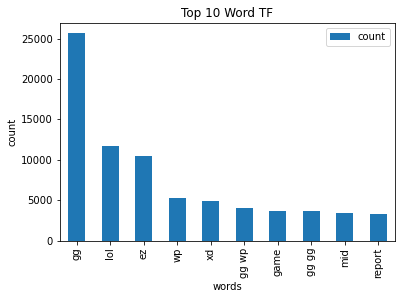

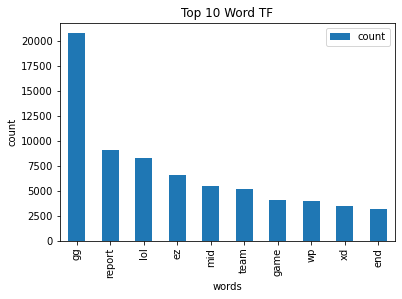

In [27]:
wint_us_vec = gram13_cv.fit_transform(wint_us)
plot_freq(gram13_cv, wint_us_vec)
loset_us_vec = gram13_cv.fit_transform(loset_us)
plot_freq(gram13_cv, loset_us_vec)

### Topic Modelling

In [28]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [29]:
def display_topics(model, feature_names, no_top_words = 10):
    keyword = []
    for topic_idx,topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words = " ".join([feature_names[i]
                      for i in topic.argsort()[:-no_top_words -1 :-1]])
        print(top_words)
        keyword.append([topic_idx, top_words])
        df_keyword = pd.DataFrame(keyword, columns = ['Topic', 'word'])
    return df_keyword

In [30]:
us_chat = text_df['chat'].values
eu_chat = text_df_eu['chat'].values

In [31]:
# topics in us
us_vec = gram13_cv.fit_transform(us_chat)
lda = LDA(n_components=3, max_iter = 5, learning_method='online',
         learning_offset=50, random_state=0)
lda.fit(us_vec)
us_topic_df = display_topics(lda,gram13_cv.get_feature_names())

Topic 0:
ez lol gg mid xd ez mid report noob ty gg ez
Topic 1:
gg lol wp game gg wp gg gg just fuck team fucking
Topic 2:
gg report xd que team la el pls mid es


In [32]:
# topics in eu
eu_vec = gram13_cv.fit_transform(eu_chat)
lda = LDA(n_components=3, max_iter = 5, learning_method='online',
         learning_offset=50, random_state=0)
lda.fit(eu_vec)
us_topic_df = display_topics(lda,gram13_cv.get_feature_names())

Topic 0:
не ты на изи гг сука репорт что gg как
Topic 1:
report game ez pls team mid lol fucking just nice
Topic 2:
gg wp gg wp ez lol gg gg ggwp wp gg xd gl


In [33]:
# vectorization
win_us_vec = gram13_cv.fit_transform(wint_us)
# topic modelling for winning team in Europe
lda = LDA(n_components=4, max_iter = 5, learning_method='online',
         learning_offset=50, random_state=0)
lda.fit(win_us_vec)
win_us_topics_df = display_topics(lda, gram13_cv.get_feature_names())

Topic 0:
gg wp gg wp gg gg lol ggwp commend lol gg wp gg ty
Topic 1:
ez xd lol gg mid report ez ez ez mid que noob
Topic 2:
lol gg ez game just nice fuck im guys good
Topic 3:
sec usa usa usa usa usa usa wait peru viva lag void leave


In [34]:
# vectorization
lose_us_vec = gram13_cv.fit_transform(loset_us)
# topic modelling for winning team in Europe
lda = LDA(n_components=4, max_iter = 5, learning_method='online',
         learning_offset=50, random_state=0)
lda.fit(lose_us_vec)
lose_eu_topics_df = display_topics(lda, gram13_cv.get_feature_names())

Topic 0:
que xd el la es se mierda usa por usa usa
Topic 1:
report ez gg mid team pls noob end ez mid lol
Topic 2:
gg wp gg wp gg gg lol ggwp lol gg wp gg ty gg gg gg
Topic 3:
lol game just fucking gg shit team fuck im like


In [35]:
# vectorization
win_eu_vec = gram13_cv.fit_transform(wint_eu)
# topic modelling for winning team in Europe
lda = LDA(n_components=4, max_iter = 5, learning_method='online',
         learning_offset=50, random_state=0)
lda.fit(win_eu_vec)
win_eu_topics_df = display_topics(lda, gram13_cv.get_feature_names())
# lose_eu_vec = gram13_cv.fit_transform(loset_eu)
# win_us_vec = gram13_cv.fit_transform(wint_us)
# lose_us_vec = gram13_cv.fit_transform(loset_us)
# get word list
# word_list = gram13_cv.get_feature_names()

Topic 0:
не изи ты гг gg на ez сука как вы
Topic 1:
gg wp gg wp gg gg ez lol ggwp wp gg ty gg ez
Topic 2:
min pudge 10 game rage like kek sry xd good
Topic 3:
ez lol game report nice gg xd mid fuck dont


In [36]:
# vectorization
lose_eu_vec = gram13_cv.fit_transform(loset_eu)
# topic modelling for winning team in Europe
lda = LDA(n_components=4, max_iter = 5, learning_method='online',
         learning_offset=50, random_state=0)
lda.fit(lose_eu_vec)
lose_eu_topics_df = display_topics(lda, gram13_cv.get_feature_names())

Topic 0:
report ez pls mid ff wr ez mid afk end plz
Topic 1:
не репорт на сука ты гг что изи как gg
Topic 2:
game report fucking just team xd dont shit lol nice
Topic 3:
gg wp gg wp lol gg gg ty report team ez ggwp


### Trending analysis

In [37]:
# create topic distribution
def distribution(fitted_model):
    dis = []
    for i in range(len(fitted_model)):
        doc_no = i
        distribution = fitted_model[i]
        dis.append([doc_no, distribution])
    df_dis = pd.DataFrame(dis, columns = ['Document', 'Distribution'])
    return(df_dis)

In [38]:
# # sample 100 matches
# import numpy as np
# np.random.seed(0)
# sample_match = np.random.randint(49999, size = 100)
# sample_match

In [39]:
# use data frame
txt_df2 = trend_df.reset_index()
txt = txt_df2['key'].values
# vectorization
ubtf = gram13_cv.fit_transform(txt)
# get word list
word_list = gram13_cv.get_feature_names()

In [40]:
# run lda
lda = LDA(n_components = 4, max_iter = 5, learning_method='online',
         learning_offset=50, random_state=0)
lda_fitted = lda.fit_transform(ubtf)

In [41]:
lda_fitted[0]

array([0.25, 0.25, 0.25, 0.25])

In [42]:
# display topics in lda model
dfd = display_topics(lda, word_list)

Topic 0:
ez mid xd ez mid haha lmao wtf mmr like game
Topic 1:
lol game nice team fuck just end good shit ty
Topic 2:
gg report wp gg gg gg wp noob commend pls team ggwp
Topic 3:
que es la el xd jaja usa peru mierda se


In [43]:
# set a threshold for document's topic probability
threshold = 0.5
t = []
for n in range(lda_fitted.shape[0]):
    most_pr = lda_fitted[n].max()
    topic_most_pr = lda_fitted[n].argmax()
    if most_pr > threshold:
        topic = topic_most_pr
    else:
        topic = 4
    t.append(topic)
    df_topic = pd.DataFrame(t, columns = ['Topic'])
    #print("doc: {} topic: {}\n".format(n,topic_most_pr))

In [44]:
# construct dataframe used for plotting
doc_topic = pd.concat([txt_df2[['key','time']], df_topic], axis = 1)
topic_date = doc_topic[~doc_topic['Topic'].isin([4])]

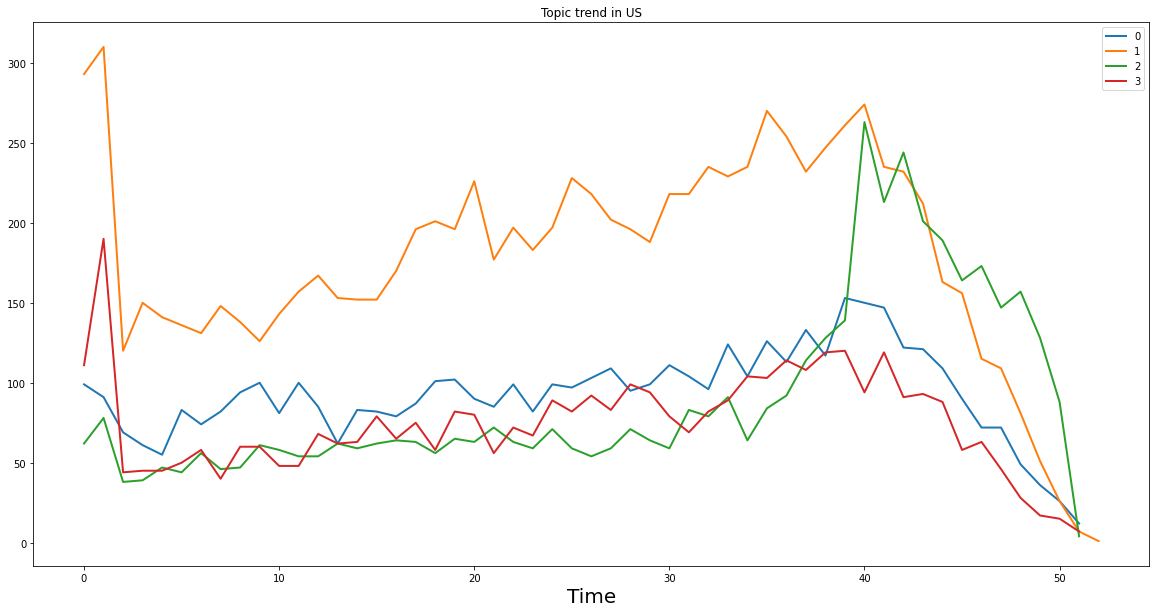

In [45]:
# plot trending
import matplotlib.pyplot as plt
%matplotlib inline
grouped = topic_date.groupby(['Topic','time'])
df_grouped = pd.DataFrame(grouped.size().reset_index(name = "Group_Count"))
# df_grouped.time = pd.to_datetime(df_grouped.time)
df_grouped.set_index('time', inplace=True)
fig, ax = plt.subplots()
for key, data in df_grouped.groupby('Topic'):
    data.plot(y = 'Group_Count', ax=ax, label=key, figsize=(20,10), linewidth=2, fontsize=10)
plt.xlabel('Time', fontsize=20)
plt.title('Topic trend in US')
plt.show()

## Classification Problem

###  Constucting MNB model

In [46]:
y = text_df['win'].values
x = text_df['chat'].values

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [48]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(20127,) (8627,) (20127,) (8627,)


In [49]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()

In [50]:
# unigram term frequency vectorization
X_train_vec = tf_vectorizer.fit_transform(X_train)
X_test_vec = tf_vectorizer.transform(X_test)

In [51]:
# train a MNB classifier
nb_clf.fit(X_train_vec, Y_train)
nb_clf.score(X_test_vec, Y_test)

0.6659325373826359

In [52]:
# unigram & bigram term frequency vectorization
X_train_vec2 = gram12_cv.fit_transform(X_train)
X_test_vec2 = gram12_cv.transform(X_test)
nb_clf2 = MultinomialNB()
nb_clf2.fit(X_train_vec2, Y_train)
nb_clf2.score(X_test_vec2, Y_test)

0.6696418221861598

In [53]:
# unigram & bigram & trigram term frequency vectorization
X_train_vec3 = gram13_cv.fit_transform(X_train)
X_test_vec3 = gram13_cv.transform(X_test)
nb_clf3 = MultinomialNB()
nb_clf3.fit(X_train_vec3, Y_train)
nb_clf3.score(X_test_vec3, Y_test)

0.6732351918395735

In [54]:
# because we have the parameter max_features in the initialization of vectorizer
# we have max number of words = max_features =1000 
# 
print(X_train_vec.shape)

(20127, 6284)


### Test the MNB classifier

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
def cross_validation(vec, clf, X, Y):
    clf_pipe = Pipeline([('vectorizer', vec),('clf', clf)])
    scores = cross_val_score(clf_pipe, X, Y, cv =5)
    avg = sum(scores)/len(scores)
    print('Accuracy by 5 folds cross validation:')
    print(avg)
    return avg

In [56]:
cross_validation(gram12_cv, nb_clf2, x, y )

Accuracy by 5 folds cross validation:
0.6692985023398578


0.6692985023398578

In [57]:
nb_clf.score(X_test_vec, Y_test)

0.6659325373826359

In [58]:
from sklearn.metrics import confusion_matrix
Y_pred_mnb = nb_clf3.predict(X_test_vec3)
cm = confusion_matrix(Y_test, Y_pred_mnb, labels =[0,1])
print(cm)

[[2316 1958]
 [ 861 3492]]


In [59]:
# print classification report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('Precision score is:')
print(precision_score(Y_test, Y_pred_mnb, average = None))
print('Recall_scroe is:')
print(recall_score(Y_test, Y_pred_mnb, average = None))

from sklearn.metrics import classification_report
target_names = ['defeat','victory']
print(classification_report(Y_test, Y_pred_mnb, target_names = target_names))

Precision score is:
[0.72898961 0.64073394]
Recall_scroe is:
[0.54188114 0.80220538]
              precision    recall  f1-score   support

      defeat       0.73      0.54      0.62      4274
     victory       0.64      0.80      0.71      4353

    accuracy                           0.67      8627
   macro avg       0.68      0.67      0.67      8627
weighted avg       0.68      0.67      0.67      8627



## ROC curve for imbalanced data set

In [60]:
ib_sample_win = text_df[text_df['win'] == 1].sample(frac = 0.9, replace = True, random_state = 0)
ib_sample_lose = text_df[text_df['win'] == 0].sample(frac = 0.1, replace = True, random_state = 0)
ib_sample = pd.concat([ib_sample_win, ib_sample_lose]).reset_index(drop = True)
yim = ib_sample['win'].values
xim = ib_sample['chat'].values
Xim_train, Xim_test, Yim_train, Yim_test = train_test_split(xim, yim, test_size = 0.3, random_state = 0)

In [61]:
# make mnb pipe
Xim_train_vec = gram13_cv.fit_transform(Xim_train)
Xim_test_vec = gram13_cv.transform(Xim_test)

In [62]:
nb_clfim = MultinomialNB()
nb_clfim.fit(Xim_train_vec, Yim_train)

MultinomialNB()

AUC score: 
 0.7320487166184935


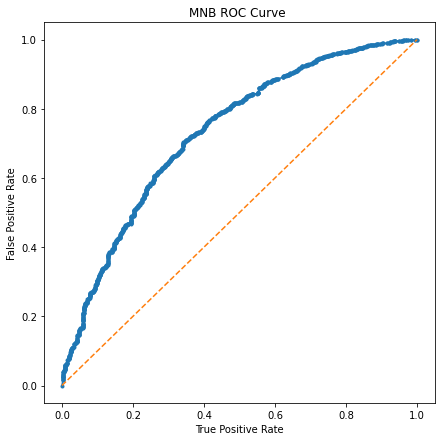

In [63]:
# ROC curve for mnb problem
from sklearn.metrics import roc_curve, roc_auc_score
#predict the probability of the data points belongs to each class
Y_mnb_pred_prob = nb_clfim.predict_proba(Xim_test_vec)
#calculate false positve, true positive rate,
#known that roc curve is TP vs. FP
FP_rate, TP_rate, threshold = roc_curve(Yim_test, Y_mnb_pred_prob[:,1])
print("AUC score: \n" ,roc_auc_score(Yim_test, Y_mnb_pred_prob[:,1]))
#plot roc curve
plt.subplots(1,figsize=(7,7))
plt.title("MNB ROC Curve ")
plt.plot(FP_rate, TP_rate, marker='.')
plt.plot([0,1], ls="--")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.show()

### Interpret a trained MNB model

In [64]:
# Interpret a trained MNB model
def show_most_and_least_informative_features(vectorizer, clf, class_idx = 0, n = 10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[class_idx], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[-n:])
    print("\tcoefficent\tWord leads to failure\t\tWord leads to victory")
    for (coef_1, fn_1),(coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [65]:
show_most_and_least_informative_features(tf_vectorizer, nb_clf)

	coefficent	Word leads to failure		Word leads to victory
	-12.3907	1vs5           		-4.9660	ty             
	-12.3907	4v6            		-4.8453	nice           
	-12.3907	65             		-4.6483	report         
	-12.3907	abuso          		-4.6142	mid            
	-12.3907	acct           		-4.5328	game           
	-12.3907	admitted       		-4.2686	xd             
	-12.3907	altoke         		-4.1990	wp             
	-12.3907	animales       		-3.4681	ez             
	-12.3907	armarse        		-3.3783	lol            
	-12.3907	assume         		-2.6018	gg             


In [66]:
show_most_and_least_informative_features(gram12_cv, nb_clf2, 0)

	coefficent	Word leads to failure		Word leads to victory
	-12.7095	100 mmr        		-4.9671	report         
	-12.7095	1vs5           		-4.9330	mid            
	-12.7095	22 minutes     		-4.8633	gg gg          
	-12.7095	40 minutes     		-4.8516	game           
	-12.7095	4v6            		-4.7804	gg wp          
	-12.7095	65             		-4.5874	xd             
	-12.7095	abuso          		-4.5178	wp             
	-12.7095	acaben rapido  		-3.7868	ez             
	-12.7095	acc buyer      		-3.6971	lol            
	-12.7095	acct           		-2.9206	gg             


In [67]:
show_most_and_least_informative_features(gram13_cv, nb_clf3, 0)

	coefficent	Word leads to failure		Word leads to victory
	-12.7554	13th           		-5.5358	este           
	-12.7554	30 seconds     		-5.5034	sup gg wp      
	-12.7554	3v5            		-5.3972	kunkka gg      
	-12.7554	ability        		-5.3846	os             
	-12.7554	afk fountain   		-4.9092	mek            
	-12.7554	ah ok          		-4.8976	lo siento      
	-12.7554	alch mid       		-4.8263	nop            
	-12.7554	alche pls      		-3.8328	gyro pls       
	-12.7554	alchemit       		-3.7431	wheres gpm yeah
	-12.7554	allahu         		-2.9665	looks          


### Error analysis

In [68]:
# win chat that are mistakenly predicted as lose chat
err_cnt = 0
for i in range(0, len(Y_test)):
    if(Y_test[i] == 1 and Y_pred_mnb[i] == 0):
        print(X_test[i])
        err_cnt += 1
print('errors:', err_cnt)

windranger,ftw,farmed winranger op hi purple brotjers,oh you have scepter,why is void always near you...,i got scepter its fine,pause or we good?,random shuffle of manta was not in your favour,wait,wait,it would have been this either way....i got farmed...my team is farmed,even with void,see,report ds? the bash,this is some internet,that was a game,gg
glhf everyone,he was trilaned,fro like 3 mintues,ggwp everyone,have a great day and god bless you,ignor ethe haters skay me too,50$ 5k acc {papiiiiiii,papiii bs going mid,free int,no def,we coming mid,im acc buyer too,rofl
pick draw = -40% win rate u pick draw,thats y i pick pa b,that was half half g
go killme,jaja,alfin,jajaja,?,xd,tipico rata de 3k,ez try top naa gg,pudge mid free mmr,?,gays?,ez?,haha pudge poor,really?,omg,haha,report wr please,:3 'cause i am pudge
lol,invo noob,:(,por la rubick mne mato lol,jaja,slark el tanque,axe de papel,invo xq me odias rctm,jaja,ese invoker mas noob,solo contra el mundo,ff,jaja,estos 2k son la ca

In [69]:
# lose chat that are mistakenly predicted as win chat
err_cnt = 0
for i in range(0, len(Y_test)):
    if(Y_test[i] == 0 and Y_pred_mnb[i] == 1):
        print(X_test[i])
        err_cnt += 1
print('errors:', err_cnt)

sec,ty,how did u know blue <3,g,enguoh compendiums>,ggwp,wow,craggy life
fucking chinese all is cool in the jungle,the mighty jungle,to hard,lol,brah come on,xd ,gg ff plz,i wont come out ,thank you ,i have no idea why they keep defending,sry ,gg wp ez mid and top,i c,gg this 2k storm,omg gg
sorry guys,gg thanks guys is anyone ever in a party?,dota > party,any day,dota == party dota = party?,man not in the games i've been playing,tactical,pong,ahahaha okay,reported and muted for future reference.
?,ez mmr,i feed,in bot,go kill me,i feed,in top,kiull me,go,please,stop,reconect,gg wp,ez sheaker,gg wp fucking shit as mid, ez life bullshit
its ok,no hurry,yo am,wtf you doing here,wut,wtf,le bear with stereoids,1 sec,ty,g?,my cat was figthing,mid is a shithole,idk,osfrog,no,nooo,no,wut,o,the ags shit on wk,never seen it before ,that's so weird,you don't really know what happening ez,im not ur friend,?,necro?,feed?,u die to mid for a support that is 1-5,thank jugg while youre at it 3 times
:

gl hf,gg,gg hohoho glhf,?,cool,gg,learn to hit a net meepo rofl
gg,gege] g '/ ?
gg wp,gg wp
i can see medusa e.e,ez ass,so ez,nice farm medusa..,ty,gg ez,xd,aggg  pudge ._.,z mid,ty,commend  brystle :3,ez pon la  tumbna,go,ajkajja  nunca,ajajja jaja me das pena gg,gg
lol,hahahah,game at over,ggwp gg,gg wp lets fucking go,wager you fucking shitstains,what the fuck?,does that mean>,soy gringo no hablo,spin,2,win,k,>coment lol ty for diving
i dont think ur good enough to talk smack,gg,tell ur mid ss who got raped in lane gg
these supports,ggwp ty,lol,gg gg wp
gg gg
让我赢啊,上把没选=-=你叫我这把选的,不要这么过分=-= gg wp gg
gg noob meirdajdoer,olo
gg
gg  we waiting for you guys,bad manner,gg,we concede we lose,ggg,?,guys,...,rofl,winter face*,ty,w8 legion please,:/,omg,i died,:(,...,gg,sure gg,guy named feed is crying like a cunt..,:(,frowny fce,,wait are u saying i have an ugly face cause that would hurt my feelings irl,no i wouldnt wait for u guys i was spamming p,p p p p p p p p p p p p p p p p p p p p p 

ditto,oh lol,gg,totally worth ez mid and top haha,such luck,bb is so clowny,gg,bb op,ik lol,that shit is ridiculous,lmao',lol gg
gg,ggwp lel,gg gg gg
worth,gg gg,gg ups,3 hp,man,ez
? gg
payaso,ez gg
wow,that was absurd worth it slark?,gg lol lion,dusa killed your ass,gg,too many throws ya,give u health discussing it ,seems like the right move,good chase,that glimpse steal would have been pro if it had brought you back further,hes got a lot of heart,fun match,i hope your teammates did not flame you as hard as ours,not fun 
1 min,1 min,gg kkk,gg ggwp
yup, we couldnt counter the dazzle,and?,with farm yes gg gg he bought the 1 way ticket
whats upppp,why?,troll what? ,it's just after noon...? lol,this bounty hunter be special,lol pa laughs like he helped at all,run your bitch ass outta here lol,pa you're terrible lmfao,i will wreck you every single time,you would never have a prayer,pa mvp,lmfao bh you scrub,uninstall pa :c,?,bounty = gay,gg gg?,lol run,nice bb,ez game,no,get towers boys,lo

lol invis,4k scrub,sorry,4k too,but better than u,lol,storm,ur frind,3k better,than uy,ez 4k,yeah,thats why im losing,lel,nice trade,ik,cuzz im good,lel,ez,lel xd
bye,hey guys let's try to jump tiny and shaman with their whole team off map,what could go wrong,this kunk is retarded,him and doom are game losing,nice death pudge,i knew i lost,when i looked up,and my kunk,and doom,feed first 15 mins,lol evidence = erased,fck i'm playing bd lul,?,kk,god this is some cringeworthy play from me sorry tema,how did pudge,i will doom you bcezuse you hvae 9 spells,3!,gg yeah,worth
ggg,r eport lunda
gg gg,por la maldita actualizacion no mas gg,lol,gg
lol,wtf buenos tacos alch with the 1k gold,is that 5k,5x 1k,pls,geegee,lol angry trees
gg boys,could have just asked our es,hes happy to helpout,thats it,im feeding,lol,what,come on,hes feeding,why pause,go o m g,he playing with his pee pee ?,oh sweet im doing that too,buddy lets all watch some swamp monster porn together,i hate my life,i want to kill 

viva la peru,en peru somos hermosos,en peru somos hermosos,:v,ty peru,ez la peru,sta fedeando dice,ez peru ',ez mid ? bitch please ez mid
i dont get how these teams get compiled,gotta give pudge some credit hi, im a tree and i will put my sticks in your ass,gg,gg,3vs5 so hard,including you of course,useless wind and lich,gg
oh shit bro,rip bob,that 298carry gpm,wohoo am in trees,gg,pausing to celebrate am battlefury,35min gg,eh, just our ancient.  we can come back from that. ?,ggwp
gl hf,yeah gg wp,hey man. as long as we aint peruvian,no one hear can speak your shit language. nor does anyone care what you have to say!,here gl hf,gg,we got out played lol
i rate it loss?,whats loss?,tjhere was a doom?,ya gg,lol,da fuk
not bad,;),*wp finally landed ur lucky ass hook,gg wp,wow,didnt think u guys would come back
gg wp,quick blame someone! pro kunkka,last random lol worth report this shit gg wp
hahaha,pudge noob,wk noob,ez game,please help me to report pudge and wk,please,xd..!1,lol,please r

wow,lifestealer sucks,so much,lol,in this patch, so much,don't flatter yourself lol,lifestealer just needs too much,it's not even the counterpicks, lifestealer needs to be ahead on farm, can't flash farm and doesn't play well from behind,something my teamates sure loved when they fed,i randomed,couldn't repick in time why me,ye,lifestealer suck a lil bit in this patch :o,also,lol,random ?
b good luck have fuhn five,bait
gg gg gg dota
bet coins,aaaaaaaaaaaaaaaah
lag?,some issue,any moment,no followup under tower and tombstone,such noobs we are,twas ez wp
lol,geegee slark lol,noobs  4 slark,no he was afk before deconnect,ask axe he kill him will afk ;) report slark,gg lol,loool,hi bb
gg wp rip,gg
gg wr,gj,),ggwp,finish,mb,pro wk,with sange and yasha ggwp
bo,gg,w[,wp cent spanish?
ez bot,gg,mid no gank,g,what??,ty,gg,very ez,nice picks,bkb ,gg nice solo offlane
==,肾不好,原谅他 da jia hao,wo shi shabi,ggggg
gg,lol gg wp ???
wp,gg whatever.,top was fucked up because our offlane is like..,no tp's

### SVM

In [70]:
#unigram tfidf vecotorizer
unigram_tfidf = TfidfVectorizer(encoding='latin-1', min_df = 5,stop_words ='english')
# unigram & bigram tfidf vecotorizer
gram12_tfidf = TfidfVectorizer(encoding='latin-1', min_df = 5,stop_words ='english', ngram_range=(1,2))
# unigram & bigram & trigram tfidf vecotorizer
gram13_tfidf = TfidfVectorizer(encoding='latin-1', min_df= 5,stop_words ='english',ngram_range=(1,3))

In [71]:
# vectorize training data and test data
from sklearn.svm import LinearSVC
X_train_vec_idf = unigram_tfidf.fit_transform(X_train)
X_test_vec_idf = unigram_tfidf.transform(X_test)
svm_clf = LinearSVC(C=1, max_iter=2000,random_state = 0)
svm_clf.fit(X_train_vec_idf, Y_train)
svm_clf.score(X_test_vec_idf, Y_test)

0.6483134345658977

In [72]:
# vectorize training data and test data using unigram & bigram
X_train_vec_idf12 = gram12_tfidf.fit_transform(X_train)
X_test_vec_idf12 = gram12_tfidf.transform(X_test)
svm_clf2 = LinearSVC(C=1, max_iter=2000,random_state = 0)
svm_clf2.fit(X_train_vec_idf12, Y_train)
svm_clf2.score(X_test_vec_idf12, Y_test)

0.6564274950736061

### Tuning on hyperparameters C

In [74]:
# vectorize training data and test data using unigram & bigram & trigram
X_train_vec_idf13 = gram13_tfidf.fit_transform(X_train)
X_test_vec_idf13 = gram13_tfidf.transform(X_test)
svm_clf3 = LinearSVC(C=0.1, max_iter=2000,random_state = 0)
svm_clf3.fit(X_train_vec_idf13, Y_train)
svm_clf3.score(X_test_vec_idf13, Y_test)

0.6842471311000348

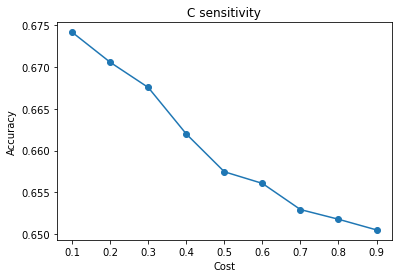

In [75]:
import numpy as np
C = np.arange(0.1, 1, 0.1)
acc_svm = []
for c in C:
    svm = LinearSVC(C = c)
    svm.fit(X_train_vec_idf13, Y_train)
    acc = cross_val_score(svm, X_test_vec_idf13, Y_test, cv = 5)
    avg_acc = sum(acc)/len(acc)
    acc_svm.append(avg_acc)
plt.plot(C, acc_svm, marker = 'o')
plt.title('C sensitivity')
plt.xlabel('Cost')
plt.ylabel('Accuracy')
plt.show()

#### Vectorization using trigram has the best performance on svm.

### Interpret trained SVM model

In [76]:
feature_ranks = sorted(zip(svm_clf3.coef_[0], gram13_tfidf.get_feature_names()))

In [77]:
fail_word = feature_ranks[:10]
print('Words lead to failure')
for i in range(0, len(fail_word)):
    print(fail_word[i][1])
print()

Words lead to failure
end
team
report
ff
mid
vs
carrys
finish
just end
hc



In [78]:
win_word = feature_ranks[-10:]
print('Words lead to victory')
for i in range(0, len(win_word)):
    print(win_word[i][1])
print()

Words lead to victory
sorry
comeback
recomienden
recomend
izi
voltis
let end
ez
commend
comend



### Test the SVM classifier

In [79]:
# cross validation
cross_validation(gram13_tfidf,svm_clf3,x,y)

Accuracy by 5 folds cross validation:
0.6852960528603722


0.6852960528603722

In [80]:
# print confusion matrix
Y_pred_svm = svm_clf3.predict(X_test_vec_idf13)
cm = confusion_matrix(Y_test, Y_pred_svm, labels =[0,1])
print(cm)

[[2837 1437]
 [1287 3066]]


In [81]:
# print classification report

print('Precision score is:')
print(precision_score(Y_test, Y_pred_svm, average = None))
print('Recall_scroe is:')
print(recall_score(Y_test, Y_pred_svm, average = None))

from sklearn.metrics import classification_report
target_names = ['defeat','victory']
print(classification_report(Y_test, Y_pred_svm, target_names = target_names))

Precision score is:
[0.68792435 0.68087941]
Recall_scroe is:
[0.663781   0.70434183]
              precision    recall  f1-score   support

      defeat       0.69      0.66      0.68      4274
     victory       0.68      0.70      0.69      4353

    accuracy                           0.68      8627
   macro avg       0.68      0.68      0.68      8627
weighted avg       0.68      0.68      0.68      8627



In [82]:
# make mnb pipe
Xim_train_vec_idf = gram13_tfidf.fit_transform(Xim_train)
Xim_test_vec_idf = gram13_tfidf.transform(Xim_test)

In [83]:
Xim_train_vec_idf

<10131x9855 sparse matrix of type '<class 'numpy.float64'>'
	with 252378 stored elements in Compressed Sparse Row format>

In [84]:
svm_clfim = LinearSVC(C=0.1, max_iter=2000,random_state = 0)
svm_clfim.fit(Xim_train_vec_idf, Yim_train)

LinearSVC(C=0.1, max_iter=2000, random_state=0)

AUC score: 
 0.757178722300452


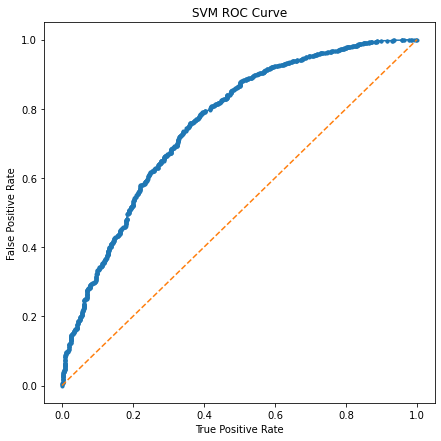

In [85]:
# ROC curve for svm problem
from sklearn.metrics import roc_curve, roc_auc_score
#predict the probability of the data points belongs to each class
Y_svm_pred_prob = svm_clfim.decision_function(Xim_test_vec_idf)
#calculate false positve, true positive rate,
#known that roc curve is TP vs. FP
FP_rate, TP_rate, threshold = roc_curve(Yim_test, Y_svm_pred_prob)
print("AUC score: \n" ,roc_auc_score(Yim_test, Y_svm_pred_prob))
#plot roc curve
plt.subplots(1,figsize=(7,7))
plt.title("SVM ROC Curve")
plt.plot(FP_rate, TP_rate, marker='.')
plt.plot([0,1], ls="--")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.show()

### Error analysis

In [86]:
# win chat that are mistakenly predicted as lose chat
err_cnt = 0
for i in range(0, len(Y_test)):
    if(Y_test[i] == 1 and Y_pred_svm[i] == 0):
        print(X_test[i])
        print()
        err_cnt += 1
print('errors:', err_cnt)

gg gg this one is in the bag,what team are you,wildcats gg

teeaaaaam,i had the tonker teammmm

windranger,ftw,farmed winranger op hi purple brotjers,oh you have scepter,why is void always near you...,i got scepter its fine,pause or we good?,random shuffle of manta was not in your favour,wait,wait,it would have been this either way....i got farmed...my team is farmed,even with void,see,report ds? the bash,this is some internet,that was a game,gg

glhf everyone,he was trilaned,fro like 3 mintues,ggwp everyone,have a great day and god bless you,ignor ethe haters skay me too,50$ 5k acc {papiiiiiii,papiii bs going mid,free int,no def,we coming mid,im acc buyer too,rofl

pick draw = -40% win rate u pick draw,thats y i pick pa b,that was half half g

gg probably not,damn you got me ur soul shall suffer,victory or death,my magic will tear u apart,yeah!,juggernaur ur an imbecile nature will rise against you

so slowwww,ty for stop,no u,but he teh green arow,fukd at,im out,ugh,we useless i kno,

go,ty,.)  i get shit team,nice random,nice mid,haha,nice try 1 sec,.i.

retards,?,?,people pick lesh and wins the game,shame on you,this is so cool,?,im so good at this game,nice counter pickls,so good,this is a 5k game btw,ez ur pretty bad at veno,how do u not beat ta mid with veno,my team owns,^,im preetty sure i had liek 50 cs at 8 min,idk how he can say he won mid,yolo  xd,tower defence game,veno countered,sure you did,the hates

does he even have his boots yet,lol,watch the replay,it was over from the very start cus he doesnt wait to level his skill,lol,gg,ez entire map sht,idk,how alche lost mid,vs puck,oh wo,oh ok,nah,170 it not lag,170 it is normal,ping lol,the throws,2 hits,gg,lol,or why invoker was top,gg

lol 3-22,rofl,key kotl,1-6,?,what a useless riki g,jealous how is it up there? magnus?,boom's on your way down,u can go back your dark home,please dont,i need mana,i got 6000..,6800 sry

lol,np farming alche,dont pick drow,np was a shitty pick,peruvians?,maybe,lol espace cr

In [87]:
# lose chat that are mistakenly predicted as win chat
err_cnt = 0
for i in range(0, len(Y_test)):
    if(Y_test[i] == 0 and Y_pred_svm[i] == 1):
        print(X_test[i])
        print()
        err_cnt += 1
print('errors:', err_cnt)

sorry guys,gg thanks guys is anyone ever in a party?,dota > party,any day,dota == party dota = party?,man not in the games i've been playing,tactical,pong,ahahaha okay,reported and muted for future reference.

?,ez mmr,i feed,in bot,go kill me,i feed,in top,kiull me,go,please,stop,reconect,gg wp,ez sheaker,gg wp fucking shit as mid, ez life bullshit

welcome to my jungle yep ez game,how sad not  gg gg afk jungle carried you to victory,^

jajaja peru swag gg izi mid xd,yumam is not even close to making me cum,ahhhhhhhhhhhhhhhhhhhhhhhhhh,ur mom is american,gg izi mid

shit!,gg,wp ,xd!,reqally?,lol,really?,gg,lol,lol,nob,lol,comend please que xuxa hablaras rata de sven ,que xuxa es mexican cagada de sven ,mrd

?,lol what,fighting every damn game,fuck me,haha,gg ur moms a fat whore,thanks for ur mmr,after i pound u in the ass,ill fuck u till u love me,idc if invoker carries me,ill take ur mmr just the same,he's gona rape u,he's too good for u,u already know it,ya they both suck,dicks,my bo

:vvvvv ez mid.... its been gg lol

gg well played gg ggwp

? no dust,the whole game,g,g,dude,nobody buyed dust,thats why u did so good lol gg wp,horseshit teams

lol

xd,wathhh?,xd,?,toam perrra,xd,:d p gl hf,is this ranked?,te voy hacer famoso pero por periquero,caca legion rofl,rofl,ese legion mas manco q e visto

apestas,cholo ctmadre,u sucks,stupid braindead,need some helps,trash 4k,u guys,so fcking pro,dude,go league please,awfawfawfawfawfawfaw,stpid cancers,u so pro dude,g frankfurt please,u lost money now,this peruvians,so fcking toxic,thx valve ,l,dogshit,ay lmao gg

gg gg gg

? dial up?,g? he is one grumpy care bear,gg wp,i picked dazzle!!,gg wp your mom when i fucked her in the ass,rekt,i shoot rainbows of hate,beautiful rainbows,but still filled with hate,gg,jungle wraith king..............

let it go,gg really!,for fuck sake!,you guys know what you are doing,were were those people in my last game,good plays winter and rubic,all i asked,was for one crit dagger,or a bit or el

gege all mid pls ez mid ez win,ez top ez mid rofl hell no,commend my team they carried your team harder

gg ez hero,slardr so dirty,fuck ,u,slardar dont throw rocks in a glass house

wasted it,on us ayyy,went down swinging,suckers gg,jokes on you, ill never fall for that lv 1 rosh again gg wp

gg wow,suck it son,:),thnx for the pause btw helped me out :),na man,lol,lol wat,ah aya :),gg,gg

wow,wp,gg

rofl,rofl gg ? gg wp

sven gone,gg wp

rich,grill,d:,nice ward there bk\,suidoku

gg wp ggwp lol, such bad manners,gg wp ggwp,dont bm...,jesus,fuck you kid

how do u get items,gg wp gl hf gg,gg gg wp

still?,ggwp ok,dumb,bez mama,bad,man,fuck off,gg wp,ez mid ?,rofl,im 13-5 xd,l;ol

lmao mah cheeks,ggs rolf,gg,gg agreed,the plays!!!!!,lol,goood,gg wp thx,nice!,pureluck all the way?,gg

ful,ya,rofl,ahahhahaha,ahhahahaha,satisfied,ez,fight gg,we had some good plays team,gem was probably a mistake,long battle for bot rax,i'm satisfied,gg

lol gg ezs,lol,go run,ez ,ez ptm,me cagan ekl dota ctm

gg wp  gg wp

twd 2nite,can udie,lol ayylmao,go electric,still got a kill lmao,obviously,blademail wins games,im mlg,no rng 4 me,gg wp,report ancient 0 - 1 -0 report aclhe please bvaiting is the worst,brb,need to get tissuebox,for my tears,commend if u cry every time,bristle heals faster than i deals :(,rekt,fucking noob,ez kill,ez kill,ez kill,fucking rekt noob,lets change that boys,fuckin eziest kill ever,lol ^,thanks,to be fair, i wanted am,rosh,rosh,rosh,lets rosh,team lets rosh,ez,ur dick isnt rng,fukin idiot,u cant bvait me,megassssss,no megasssssss

solo  esper  que ganes :),:),v,:) lol

o___o,lol,xd,:v,xd,ez  mirana :o,fail mje,uhmm,lol,jaj,jaja,pf,gg hi,le da poder,absoluto,es dios wait please,for lag,arastralos,becerrp,te salvas que sigo con lag,te salvas no se salvan,que hace la bkb?,por que te la lanzaste¿,report slark

kappa,55 min,real easy u were so shit jug,stay 2.8 jk gg

why are you here tard nice,bash,gg go nxt,tusk,viva peru

gg,gg '?,gg

just like u,bo' may` chap',